In [3]:
pip install aif360

Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys
import numpy as np
import pandas as pd
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import copy
from IPython.display import display
from aif360.datasets import MEPSDataset19
from aif360.datasets import StandardDataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from clearbox_engine import Dataset, Preprocessor, TabularEngine, LabeledSynthesizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


# Ensure reproducibility
np.random.seed(1)

# Append a path if needed
sys.path.append("../")

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [2]:
def further_preprocessing_aif360(meps_dataset):

    # Convert MEPSDataset19 to a DataFrame
    df, metadata = meps_dataset.convert_to_dataframe()

    # Step 1: Clean invalid values for PCS42 and MCS42
    for col in ['PCS42', 'MCS42']:
        if col in df.columns:
            # Replace negative values with NaN
            df[col] = df[col].apply(lambda x: pd.NA if x < 0 else x)
            # Fill NaN values with the column median
            df[col] = df[col].fillna(df[col].median(skipna=True))


    #Scaling them offers better accuracy but slightly worse fairness metrics
    # Step 2: Scale numerical features
    #scaler = StandardScaler()
    #df[['PCS42', 'MCS42']] = scaler.fit_transform(df[['PCS42', 'MCS42']])


    # Step 3: Group age into decades
    df['Age (decade)'] = df['AGE'].apply(lambda x: min(x // 10 * 10, 70))

    # Step 4: One-hot encode categorical columns
    categorical_columns = ['Age (decade)']
    df = pd.get_dummies(df, columns=categorical_columns)

    # Rename one-hot encoded columns to remove `.0` suffix
    df.rename(columns=lambda col: col.replace('.0', '') if 'Age (decade)' in col else col, inplace=True)

    # Dynamically retrieve column names for encoded categories
    age_decade_columns = [col for col in df.columns if 'Age (decade)_' in col]

    # Step 5: Rename SEX column and convert RACE
    df.rename(columns={'SEX=1': 'SEX'}, inplace=True)
    df['RACE'] = df['RACE'].replace({'White': 1.0, 'Non-White': 0.0})

    # Step 6: Include new features (POVCAT and INSCOV)
    additional_features = [
        'POVCAT=1', 'POVCAT=2', 'POVCAT=3', 'POVCAT=4', 'POVCAT=5',
        'INSCOV=1', 'INSCOV=2', 'INSCOV=3'
    ]

    # Ensure these additional features are present in the dataset
    for feature in additional_features:
        if feature not in df.columns:
            raise ValueError(f"Feature {feature} not found in the dataset.")

    # Step 7: Retain only necessary columns
    selected_columns = (
        ['RACE', 'SEX', 'PCS42', 'MCS42'] +  # Include numerical and protected attributes
        age_decade_columns +
        additional_features +
        ['UTILIZATION']  # Include target variable
    )
    df = df[selected_columns]

    # Step 8: Create the processed AIF360 dataset
    processed_dataset = StandardDataset(
        df,
        label_name='UTILIZATION',
        favorable_classes=[1.0],
        protected_attribute_names=['RACE', 'SEX'],
        privileged_classes=[[1.0], [1.0]],  # Privileged groups: White and Male
    )

    return processed_dataset

meps = MEPSDataset19()

processed_meps = further_preprocessing_aif360(meps)


In [3]:
random_seed = 42
privileged_groups = [{'RACE': 1}]
unprivileged_groups = [{'RACE': 0}]
preprocessed_dataset= processed_meps
train, val_test = preprocessed_dataset.split([0.7], shuffle=True, seed=random_seed)
val, test = val_test.split([0.5], shuffle=True, seed=random_seed)

In [4]:
def aif360_to_clearbox(aif360_dataset, target_column):

    df, _ = aif360_dataset.convert_to_dataframe()

    if 'RACE' in df.columns:
        df['RACE'] = df['RACE'].replace({1.0: "Privileged", 0.0: "Unprivileged"})
    if 'SEX' in df.columns:
        df['SEX'] = df['SEX'].replace({1.0: "Male", 0.0: "Female"})

    return Dataset(
        data=df,
        target_column=target_column,
        regression=False,  
        name="Converted AIF360 Dataset"
    )

In [5]:
def filter_dataset_for_positive_race(dataset, unprivileged_race="Unprivileged", target_value=1.0):
    features_array = dataset.get_x()
    labels_array = dataset.get_y()
    features_df = pd.DataFrame(features_array, columns=dataset.x_columns())
    mask = (features_df["RACE"] == unprivileged_race) & (labels_array == target_value)
    filtered_features = features_df.loc[mask]
    filtered_labels = pd.Series(labels_array).loc[mask].reset_index(drop=True)
    combined_df = pd.concat([filtered_features.reset_index(drop=True), filtered_labels.rename("UTILIZATION")], axis=1)
    return Dataset(
        data=combined_df,
        column_types=dataset.column_types,
        target_column="UTILIZATION",
        regression=dataset.regression
    ), combined_df

def generate_multiple_synthetic_datasets(
    dataset_df, 
    target_column, 
    engine_class, 
    num_datasets, 
    epochs=5, 
    learning_rate=0.001, 
    half=False, 
    extra_percentage=0.5
):

    dataset = Dataset(
        data=dataset_df,
        target_column=target_column,
        column_types=None,
        regression=False,
    )
    preprocessor = Preprocessor(dataset)
    X = preprocessor.transform(dataset.get_x())

    label_encoder = LabelEncoder()
    Y = label_encoder.fit_transform(dataset.get_y()).reshape(-1, 1)  # Convert to numerical and reshape
    
    # Ensure all data types are numerical
    X = X.astype(float)
    Y = Y.astype(float)

    engine = engine_class(
        license_key=LICENSE_KEY,
        layers_size=[50],
        x_shape=X.shape[1:],
        y_shape=Y.shape[1:],
        ordinal_feature_sizes=preprocessor.get_features_sizes()[0],
        categorical_feature_sizes=preprocessor.get_features_sizes()[1],
    )

    print("Training Tabular Engine...")
    engine.fit(X, y_train_ds=Y, epochs=epochs, learning_rate=learning_rate)

    synthesizer = LabeledSynthesizer(dataset, engine)

    # Generate the main synthetic datasets
    synthetic_data_list = [synthesizer.generate(has_header=True) for _ in range(num_datasets)]
    
    # Add a partial synthetic dataset if `half` is True
    if half:
        extra_data_size = int(len(dataset_df) * extra_percentage)
        print(f"Generating an extra partial synthetic dataset of size: {extra_data_size}")
        extra_synthetic_data = synthesizer.generate(has_header=True).sample(n=extra_data_size, random_state=42)
        synthetic_data_list.append(extra_synthetic_data)

    # Combine all synthetic datasets
    concatenated_synthetic_data = pd.concat(synthetic_data_list, axis=0, ignore_index=True)
    
    return concatenated_synthetic_data


In [6]:
train_dataset = aif360_to_clearbox(train, target_column="UTILIZATION")
test_dataset = aif360_to_clearbox(test, target_column="UTILIZATION")
val_dataset = aif360_to_clearbox(val, target_column="UTILIZATION")


train_filtered_dataset, train_filtered_df = filter_dataset_for_positive_race(
    train_dataset, unprivileged_race="Unprivileged"
)
test_filtered_dataset, test_filtered_df = filter_dataset_for_positive_race(
    test_dataset, unprivileged_race="Unprivileged"
)

In [7]:
LICENSE_KEY = "licensekeyoverride2023@"
num_datasets = 1
extra_percentage = 0.5  # generate 50% of an additional dataset
half = True  # enable generating partial dataset

# Generate synthetic data for the filtered train dataset
synthetic_train_data = generate_multiple_synthetic_datasets(
    dataset_df=train_filtered_dataset.data,
    target_column="UTILIZATION",
    engine_class=TabularEngine,
    num_datasets=num_datasets,  
    half=half,
    extra_percentage=extra_percentage
)

# Generate synthetic data for the filtered test dataset
synthetic_test_data = generate_multiple_synthetic_datasets(
    dataset_df=test_filtered_dataset.data,
    target_column="UTILIZATION",
    engine_class=TabularEngine,
    num_datasets=num_datasets, 
    half=half,
    extra_percentage=extra_percentage
)

print("Synthetic Train Data Shape:", synthetic_train_data.shape)
print("Synthetic Test Data Shape:", synthetic_test_data.shape)

/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (908). n_quantiles is set to n_samples.
  warnings.warn(
2025-02-11 22:27:17.300 | INFO     | __main__:generate_multiple_synthetic_datasets:43 - I'm the Sept 2024 engine!


Clearbox AI Engine: your license is valid.
Training Tabular Engine...


Engine fitting in progress: 100%|██████████| 5/5 [00:02<00:00,  2.38epoch/s, Train loss:=1849585.8]
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (908). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (174). n_quantiles is set to n_samples.
  warnings.warn(
2025-02-11 22:27:21.896 | INFO     | __main__:generate_multiple_synthetic_datasets:43 - I'm the Sept 2024 engine!


Generating an extra partial synthetic dataset of size: 454
Clearbox AI Engine: your license is valid.
Training Tabular Engine...


Engine fitting in progress: 100%|██████████| 5/5 [00:01<00:00,  2.95epoch/s, Train loss:=2249537.2]
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (174). n_quantiles is set to n_samples.
  warnings.warn(


Generating an extra partial synthetic dataset of size: 87
Synthetic Train Data Shape: (1362, 21)
Synthetic Test Data Shape: (261, 21)


In [8]:
# Combine original and synthetic train data
train_transf_0 = pd.concat([train_dataset.data, synthetic_train_data], axis=0, ignore_index=True)

# Combine original and synthetic test data
test_transf_0 = pd.concat([test_dataset.data, synthetic_test_data], axis=0, ignore_index=True)

train_0 = train_dataset.data
test_0 = test_dataset.data
val_0 = val_dataset.data

print("Train Dataset (Original) Shape:", train_0.shape)
print("Train Dataset (Combined with Synthetic) Shape:", train_transf_0.shape)
print("Test Dataset (Original) Shape:", test_0.shape)
print("Test Dataset (Combined with Synthetic) Shape:", test_transf_0.shape)
print("Validation Dataset Shape:", val_0.shape)


Train Dataset (Original) Shape: (11081, 21)
Train Dataset (Combined with Synthetic) Shape: (12443, 21)
Test Dataset (Original) Shape: (2375, 21)
Test Dataset (Combined with Synthetic) Shape: (2636, 21)
Validation Dataset Shape: (2374, 21)


In [9]:
def preprocess_for_binary_label_dataset(df, target_column):
    df = df.copy()
    
    if target_column in df.columns:
        df[target_column] = df[target_column].astype(float)
    
    if 'RACE' in df.columns:
        df['RACE'] = df['RACE'].map({'Privileged': 1.0, 'Unprivileged': 0.0})
    
    if 'SEX' in df.columns:
        df['SEX'] = df['SEX'].map({'Male': 1.0, 'Female': 0.0})
    
    return df.astype(float)

In [10]:
# Preprocess train, test, and validation datasets
processed_train = preprocess_for_binary_label_dataset(train_0, target_column="UTILIZATION")
processed_test = preprocess_for_binary_label_dataset(test_0, target_column="UTILIZATION")
processed_val = preprocess_for_binary_label_dataset(val_0, target_column="UTILIZATION")

# Update the protected attribute to use 'RACE'
protected_attributes = ['RACE']

# Convert processed datasets to BinaryLabelDataset
train = BinaryLabelDataset(
    favorable_label=1.0,
    unfavorable_label=0.0,
    df=processed_train,
    label_names=["UTILIZATION"],  # Target column
    protected_attribute_names=protected_attributes
)

test = BinaryLabelDataset(
    favorable_label=1.0,
    unfavorable_label=0.0,
    df=processed_test,
    label_names=["UTILIZATION"],  # Target column
    protected_attribute_names=protected_attributes
)

val = BinaryLabelDataset(
    favorable_label=1.0,
    unfavorable_label=0.0,
    df=processed_val,
    label_names=["UTILIZATION"],  # Target column
    protected_attribute_names=protected_attributes
)

# Evaluate fairness metrics before applying transformations
privileged_groups = [{'RACE': 1.0}]  
unprivileged_groups = [{'RACE': 0.0}]  

metric_train = BinaryLabelDatasetMetric(train, unprivileged_groups, privileged_groups)
print("Train Dataset (Before Transformation):")
print(f"  Statistical Parity Difference: {metric_train.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_train.disparate_impact():.4f}")

metric_test = BinaryLabelDatasetMetric(test, unprivileged_groups, privileged_groups)
print("\nTest Dataset (Before Transformation):")
print(f"  Statistical Parity Difference: {metric_test.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_test.disparate_impact():.4f}")

Train Dataset (Before Transformation):
  Statistical Parity Difference: -0.1264
  Disparate Impact: 0.5029

Test Dataset (Before Transformation):
  Statistical Parity Difference: -0.1491
  Disparate Impact: 0.4347


In [11]:
# Preprocess transformed datasets
processed_train_transf = preprocess_for_binary_label_dataset(train_transf_0, target_column="UTILIZATION")
processed_test_transf = preprocess_for_binary_label_dataset(test_transf_0, target_column="UTILIZATION")

# Convert transformed datasets to BinaryLabelDataset
train_transf = BinaryLabelDataset(
    favorable_label=1.0,
    unfavorable_label=0.0,
    df=processed_train_transf,
    label_names=["UTILIZATION"], 
    protected_attribute_names=["RACE"]  
)

test_transf = BinaryLabelDataset(
    favorable_label=1.0,
    unfavorable_label=0.0,
    df=processed_test_transf,
    label_names=["UTILIZATION"],  
    protected_attribute_names=["RACE"]  
)

# Evaluate fairness metrics after applying transformations
metric_train_after = BinaryLabelDatasetMetric(train_transf, unprivileged_groups, privileged_groups)
print("\nTrain Dataset (After Transformation):")
print(f"  Statistical Parity Difference: {metric_train_after.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_train_after.disparate_impact():.4f}")

metric_test_after = BinaryLabelDatasetMetric(test_transf, unprivileged_groups, privileged_groups)
print("\nTest Dataset (After Transformation):")
print(f"  Statistical Parity Difference: {metric_test_after.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_test_after.disparate_impact():.4f}")


Train Dataset (After Transformation):
  Statistical Parity Difference: 0.0140
  Disparate Impact: 1.0549

Test Dataset (After Transformation):
  Statistical Parity Difference: -0.0192
  Disparate Impact: 0.9272


In [12]:
classifier = RandomForestClassifier(n_estimators=100, random_state=1)

In [13]:
# Train a classifier on original training data
classifier.fit(train.features, train.labels.ravel())

# Predict on validation set
val_scores = classifier.predict_proba(val.features)[:, 1] 

In [14]:
# Select best threshold for validation set
thresholds = np.arange(0.01, 1, 0.01)
val_balanced_accs = []

for threshold in thresholds:
    val_LR_predictions = (val_scores >= threshold).astype(int)

    val_with_LR_scores = copy.deepcopy(val)
    val_with_LR_scores.labels = val_LR_predictions.reshape(-1, 1)  # Update labels with predictions

    val_metric = ClassificationMetric(val, val_with_LR_scores,
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
    balanced_acc = (val_metric.true_positive_rate() + val_metric.true_negative_rate()) / 2
    val_balanced_accs.append(balanced_acc)

best_index = np.argmax(val_balanced_accs)
best_threshold = thresholds[best_index]
best_balanced_acc = val_balanced_accs[best_index]

print(f"Best Threshold (validation): {best_threshold}")
print(f"Best Balanced Accuracy (validation): {best_balanced_acc}")

Best Threshold (validation): 0.18000000000000002
Best Balanced Accuracy (validation): 0.7215607389172584


In [15]:
# Apply the best threshold to the test set
test_scores = classifier.predict_proba(test.features)[:, 1]
test_LR_predictions= (test_scores >= best_threshold).astype(int)

# Create a copy of the test dataset and set predicted labels
test_with_LR_scores = copy.deepcopy(test)
test_with_LR_scores.labels = test_LR_predictions.reshape(-1, 1)

# Calculate fairness and performance metrics on the test set
test_metric = ClassificationMetric(test, test_with_LR_scores,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)

# Balanced Accuracy
true_positive_rate = test_metric.true_positive_rate()
true_negative_rate = test_metric.true_negative_rate()
balanced_accuracy = (true_positive_rate + true_negative_rate) / 2
print(f"Balanced Accuracy (test): {balanced_accuracy}")

# Statistical Parity Difference
statistical_parity_difference = test_metric.statistical_parity_difference()
print(f"Statistical Parity Difference (test): {statistical_parity_difference}")

# Disparate Impact
disparate_impact = test_metric.disparate_impact()
print(f"Disparate Impact (test): {disparate_impact}")

# Average Odds Difference
average_odds_difference = test_metric.average_odds_difference()
print(f"Average Odds Difference (test): {average_odds_difference}")

# Equal Opportunity Difference
equal_opportunity_difference = test_metric.equal_opportunity_difference()
print(f"Equal Opportunity Difference (test): {equal_opportunity_difference}")

# Theil Index
theil_index = test_metric.theil_index()
print(f"Theil Index (test): {theil_index}")

Balanced Accuracy (test): 0.7232753164556962
Statistical Parity Difference (test): -0.2361218086193988
Disparate Impact (test): 0.48899901518478595
Average Odds Difference (test): -0.16600275723658975
Equal Opportunity Difference (test): -0.15008646119418168
Theil Index (test): 0.10460378479974483


In [16]:
# Plot Test Metrics Over Thresholds
test_balanced_accs = []
test_disp_impacts = []
test_avg_odds_diffs = []

for threshold in thresholds:
    test_predictions = (test_scores >= threshold).astype(int)
    test_with_scores = copy.deepcopy(test)
    test_with_scores.labels = test_predictions.reshape(-1, 1)

    test_metric = ClassificationMetric(test, test_with_scores, unprivileged_groups, privileged_groups)
    test_balanced_accs.append((test_metric.true_positive_rate() + test_metric.true_negative_rate()) / 2)
    test_disp_impacts.append(test_metric.disparate_impact())
    test_avg_odds_diffs.append(test_metric.average_odds_difference())

/usr/local/lib/python3.9/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


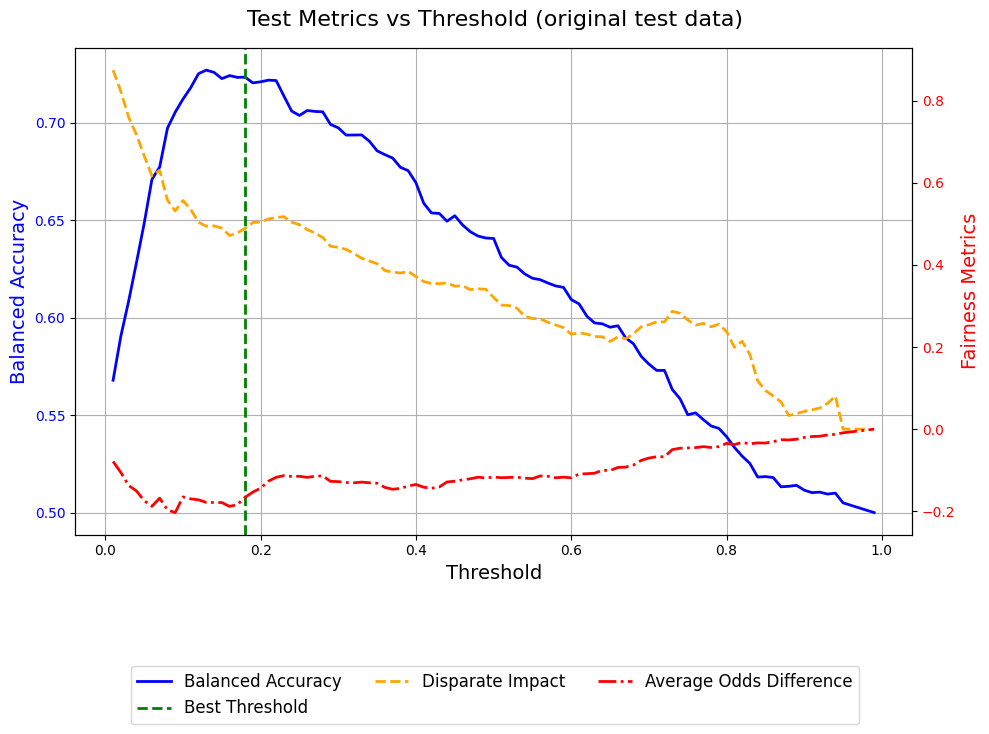

In [17]:
# Create the figure and primary y-axis for Balanced Accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

# Balanced Accuracy
ax1.plot(thresholds, test_balanced_accs, label="Balanced Accuracy", color="blue", linewidth=2)
ax1.set_xlabel("Threshold", fontsize=14)
ax1.set_ylabel("Balanced Accuracy", color="blue", fontsize=14)
ax1.tick_params(axis='y', labelcolor="blue")
ax1.grid()

# Secondary y-axis for Disparate Impact and Equal Opportunity Difference
ax2 = ax1.twinx()

# Disparate Impact
ax2.plot(thresholds, test_disp_impacts, label="Disparate Impact", color="orange", linestyle="--", linewidth=2)

# Average Odds Difference
ax2.plot(thresholds, test_avg_odds_diffs, label="Average Odds Difference", color="red", linestyle="-.", linewidth=2)

ax2.set_ylabel("Fairness Metrics", color="red", fontsize=14)
ax2.tick_params(axis='y', labelcolor="red")

# Highlight the best threshold
ax1.axvline(best_threshold, color='green', linestyle='--', linewidth=2, label="Best Threshold")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)

# Title and layout adjustments
fig.suptitle("Test Metrics vs Threshold (original test data)", fontsize=16)
fig.tight_layout()
plt.show()

In [18]:
classifier = RandomForestClassifier(n_estimators=100, random_state=1)


In [19]:
classifier.fit(train_transf.features, train_transf.labels.ravel())
# Apply the best threshold to the transf test set
test_transf_scores = classifier.predict_proba(test_transf.features)[:, 1]
test_transf_LR_predictions= (test_transf_scores >= best_threshold).astype(int)

# Create a copy of the test dataset and set predicted labels
test_transf_with_LR_scores = copy.deepcopy(test_transf)
test_transf_with_LR_scores.labels = test_transf_LR_predictions.reshape(-1, 1)

# Calculate fairness and performance metrics on the test set
test_transf_metric = ClassificationMetric(test_transf, test_transf_with_LR_scores,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)

# Balanced Accuracy
true_positive_rate = test_transf_metric.true_positive_rate()
true_negative_rate = test_transf_metric.true_negative_rate()
balanced_accuracy_transf = (true_positive_rate + true_negative_rate) / 2
print(f"Balanced Accuracy (test): {balanced_accuracy_transf}")

# Statistical Parity Difference
statistical_parity_difference_transf = test_transf_metric.statistical_parity_difference()
print(f"Statistical Parity Difference (test): {statistical_parity_difference_transf}")

# Disparate Impact
disparate_impact_transf = test_transf_metric.disparate_impact()
print(f"Disparate Impact (test): {disparate_impact_transf}")

# Average Odds Difference
average_odds_difference_transf = test_transf_metric.average_odds_difference()
print(f"Average Odds Difference (test): {average_odds_difference_transf}")

# Equal Opportunity Difference
equal_opportunity_difference_transf = test_transf_metric.equal_opportunity_difference()
print(f"Equal Opportunity Difference (test): {equal_opportunity_difference_transf}")

# Theil Index
theil_index_transf = test_transf_metric.theil_index()
print(f"Theil Index (test): {theil_index_transf}")

Balanced Accuracy (test): 0.781170072195944
Statistical Parity Difference (test): -0.11551662957504344
Disparate Impact (test): 0.74550706543493
Average Odds Difference (test): -0.030570424019506756
Equal Opportunity Difference (test): 0.12226630047807951
Theil Index (test): 0.09891977668703877


In [20]:
# Plot Test Metrics Over Thresholds
test_balanced_accs = []
test_disp_impacts = []
test_avg_odds_diffs = []

for threshold in thresholds:
    test_predictions = (test_scores >= threshold).astype(int)
    test_with_scores = copy.deepcopy(test)
    test_with_scores.labels = test_predictions.reshape(-1, 1)

    test_metric = ClassificationMetric(test, test_with_scores, unprivileged_groups, privileged_groups)
    test_balanced_accs.append((test_metric.true_positive_rate() + test_metric.true_negative_rate()) / 2)
    test_disp_impacts.append(test_metric.disparate_impact())
    test_avg_odds_diffs.append(test_metric.average_odds_difference())

/usr/local/lib/python3.9/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


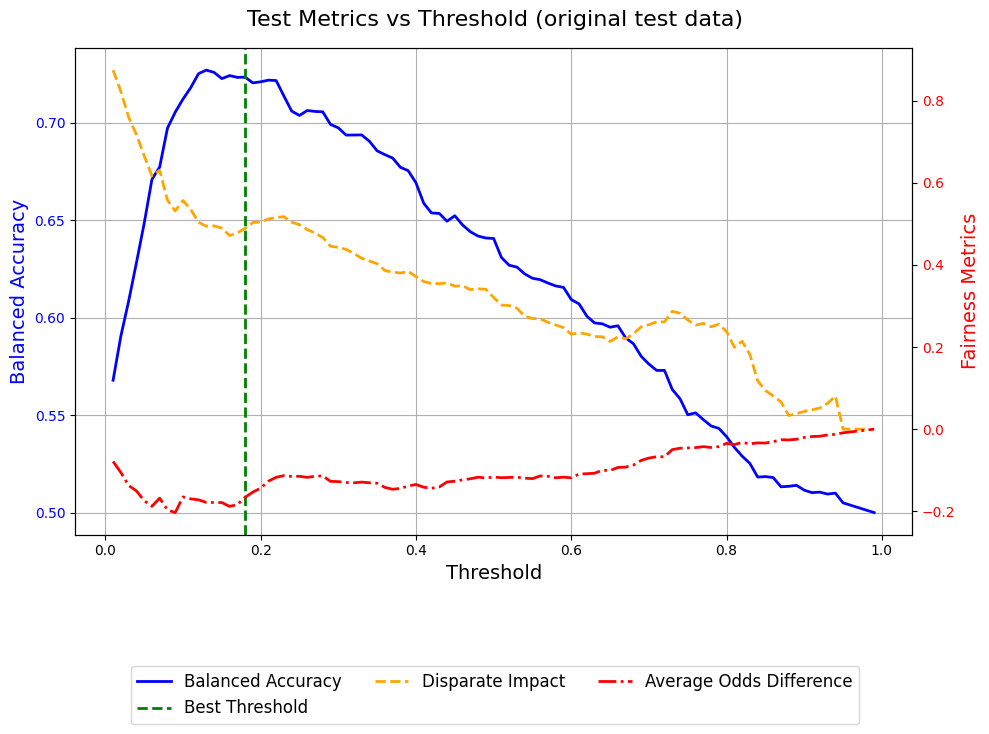

In [21]:
# Create the figure and primary y-axis for Balanced Accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

# Balanced Accuracy
ax1.plot(thresholds, test_balanced_accs, label="Balanced Accuracy", color="blue", linewidth=2)
ax1.set_xlabel("Threshold", fontsize=14)
ax1.set_ylabel("Balanced Accuracy", color="blue", fontsize=14)
ax1.tick_params(axis='y', labelcolor="blue")
ax1.grid()

# Secondary y-axis for Disparate Impact and Equal Opportunity Difference
ax2 = ax1.twinx()

# Disparate Impact
ax2.plot(thresholds, test_disp_impacts, label="Disparate Impact", color="orange", linestyle="--", linewidth=2)

# Average Odds Difference
ax2.plot(thresholds, test_avg_odds_diffs, label="Average Odds Difference", color="red", linestyle="-.", linewidth=2)

ax2.set_ylabel("Fairness Metrics", color="red", fontsize=14)
ax2.tick_params(axis='y', labelcolor="red")

# Highlight the best threshold
ax1.axvline(best_threshold, color='green', linestyle='--', linewidth=2, label="Best Threshold")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)

# Title and layout adjustments
fig.suptitle("Test Metrics vs Threshold (original test data)", fontsize=16)
fig.tight_layout()
plt.show()

In [22]:
results_data = {
    "Dataset": [
        "Train", "Train", "Test", "Test", 
        "Train", "Train", "Test", "Test", 
        "Validation", "Validation", 
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)"
    ],
    "Stage": [
        "Before Transformation", "After Transformation", 
        "Before Transformation", "After Transformation",
        "Before Transformation", "After Transformation", 
        "Before Transformation", "After Transformation",
        "Best Threshold (Validation)", "Best Threshold (Validation)",
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold"
    ],
    "Metric": [
        "Statistical Parity Difference", "Statistical Parity Difference",
        "Statistical Parity Difference", "Statistical Parity Difference",
        "Disparate Impact", "Disparate Impact",
        "Disparate Impact", "Disparate Impact",
        "Threshold", "Balanced Accuracy",
        "Balanced Accuracy", "Balanced Accuracy", 
        "Statistical Parity Difference", "Statistical Parity Difference", 
        "Disparate Impact", "Disparate Impact",
        "Average Odds Difference", "Average Odds Difference",
        "Equal Opportunity Difference", "Equal Opportunity Difference", 
        "Theil Index", "Theil Index"
    ],
    "Value": [
        metric_train.mean_difference(),
        metric_train_after.mean_difference(),
        metric_test.mean_difference(),
        metric_test_after.mean_difference(),
        metric_train.disparate_impact(),
        metric_train_after.disparate_impact(),
        metric_test.disparate_impact(),
        metric_test_after.disparate_impact(),
        best_threshold,
        best_balanced_acc,
        balanced_accuracy, balanced_accuracy_transf,
        statistical_parity_difference, statistical_parity_difference_transf,
        disparate_impact, disparate_impact_transf,
        average_odds_difference, average_odds_difference_transf,
        equal_opportunity_difference, equal_opportunity_difference_transf,
        theil_index, theil_index_transf
    ]
}

# Create the DataFrame
results_table = pd.DataFrame(results_data)
# Separate the data into three groups
fairness_metrics = results_table.iloc[0:8].reset_index(drop=True)
validation_metrics = results_table.iloc[8:10].reset_index(drop=True)
test_metrics = results_table.iloc[10:22].reset_index(drop=True)

# Name the tables
fairness_metrics.name = "Fairness Metrics Before and After Transformation"
validation_metrics.name = "Validation Metrics for Threshold Selection"
test_metrics.name = "Test Metrics After Applying Threshold On Original and Transformed"

# Display the tables with their names
for table in [fairness_metrics, validation_metrics, test_metrics]:
    display(table.name)
    display(table)

'Fairness Metrics Before and After Transformation'

,Dataset,Stage,Metric,Value
0,Train,Before Transformation,Statistical Parity Difference,-0.126402
1,Train,After Transformation,Statistical Parity Difference,0.013955
2,Test,Before Transformation,Statistical Parity Difference,-0.149086
3,Test,After Transformation,Statistical Parity Difference,-0.019191
4,Train,Before Transformation,Disparate Impact,0.502885
5,Train,After Transformation,Disparate Impact,1.054882
6,Test,Before Transformation,Disparate Impact,0.434660
7,Test,After Transformation,Disparate Impact,0.927226


'Validation Metrics for Threshold Selection'

,Dataset,Stage,Metric,Value
0,Validation,Best Threshold (Validation),Threshold,0.180000
1,Validation,Best Threshold (Validation),Balanced Accuracy,0.721561


'Test Metrics After Applying Threshold On Original and Transformed'

,Dataset,Stage,Metric,Value
0,Test (Original),After Threshold,Balanced Accuracy,0.723275
1,Test (Transformed),After Threshold,Balanced Accuracy,0.781170
2,Test (Original),After Threshold,Statistical Parity Difference,-0.236122
3,Test (Transformed),After Threshold,Statistical Parity Difference,-0.115517
4,Test (Original),After Threshold,Disparate Impact,0.488999
5,Test (Transformed),After Threshold,Disparate Impact,0.745507
6,Test (Original),After Threshold,Average Odds Difference,-0.166003
7,Test (Transformed),After Threshold,Average Odds Difference,-0.030570
8,Test (Original),After Threshold,Equal Opportunity Difference,-0.150086
9,Test (Transformed),After Threshold,Equal Opportunity Difference,0.122266


In [ ]:
#disparate impact 0.673388, 0.728573, 0.659593